In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import re
import os
import ast
import torch
import json
import random
import numpy as np
import networkx as nx
import plotly.graph_objects as go
from community import community_louvain



In [3]:
#cluster interaction matrix
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance
reduced_data = pca.fit_transform(interaction_matrix)

explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance by each component: {explained_variance}")
print(f"Number of components chosen: {pca.n_components_}")

plt.plot(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.show()

NameError: name 'interaction_matrix' is not defined

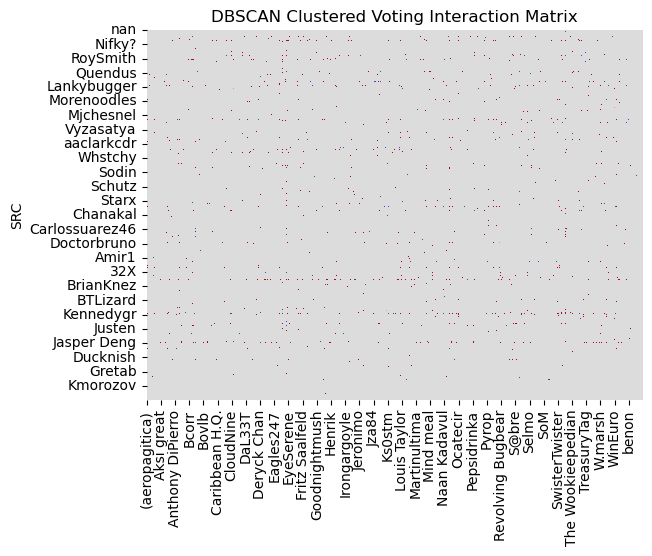

nuber of cluster: 21
Cluster labels: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [135]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

data = interaction_matrix.values

dbscan = DBSCAN(eps=0.5, min_samples=10)  
clusters = dbscan.fit_predict(data)

interaction_matrix['Cluster'] = clusters

sorted_matrix = interaction_matrix.sort_values("Cluster")

sns.heatmap(sorted_matrix.iloc[:, :-1], cmap="coolwarm", cbar=False)
plt.title("DBSCAN Clustered Voting Interaction Matrix")
plt.show()

print('nuber of cluster:',len(np.unique(clusters)))
print("Cluster labels:", np.unique(clusters))

In [4]:
# Count the number of users in each community
community_sizes = {}
for node, community in updated_partition.items():
    if community not in community_sizes:
        community_sizes[community] = 0
    community_sizes[community] += 1

community_graph = nx.Graph()

for community, size in community_sizes.items():
    community_graph.add_node(community, size=size)

for node1, node2 in G_filtered.edges:
    community1 = updated_partition[node1]
    community2 = updated_partition[node2]
    if community1 != community2:  # Only add inter-community edges
        if not community_graph.has_edge(community1, community2):
            community_graph.add_edge(community1, community2, weight=0)
        community_graph[community1][community2]['weight'] += 1

pos = nx.spring_layout(community_graph, k=20, iterations=100)

node_x = []
node_y = []
node_sizes = []
node_text = []
for node, coords in pos.items():
    node_x.append(coords[0])
    node_y.append(coords[1])
    node_sizes.append(community_graph.nodes[node]['size'] * 10)  
    node_text.append(f"Community {node}<br>Users: {community_graph.nodes[node]['size']}")
node_sizes = np.power(np.log10(node_sizes), 3) - 3

edge_traces = []
for community1, community2, data in community_graph.edges(data=True):
    x0, y0 = pos[community1]
    x1, y1 = pos[community2]
    edge_traces.append(go.Scatter(
        x=[x0, x1, None],
        y=[y0, y1, None],
        line=dict(width=0.5, color="#888"),
        hoverinfo="none",
        mode="lines",
        visible=False,  # Edges are initially hidden
        name=f"Edges for Community {community1} and {community2}"
    ))

node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode="markers+text",
    marker=dict(
        size=node_sizes,
        color=list(community_graph.nodes),
        colorscale="Viridis",
        line=dict(width=2, color="black")
    ),
    text=node_text,
    hoverinfo="text",
    customdata=list(community_graph.nodes), 
    name="Communities"
)

# Create a Plotly figure
fig = go.Figure()

for edge_trace in edge_traces:
    fig.add_trace(edge_trace)

fig.add_trace(node_trace)

fig.update_layout(
    title="Interactive Community Graph (Edges on Hover)",
    showlegend=False,
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(showgrid=False, zeroline=False),
    height=800,
    width=800,
    margin=dict(l=50, r=50, t=50, b=50)
)

def hover_fn(trace, points, state):
    for i, edge_trace in enumerate(fig.data[:-1]):  
        edge_trace.visible = False 
    hovered_node = points.customdata[0]
    for i, edge_trace in enumerate(fig.data[:-1]):
        if edge_trace.name.startswith(f"Edges for Community {hovered_node}"):
            fig.data[i].visible = True  
    fig.show()

node_trace.on_hover(hover_fn)

fig.show()

ValueError: 
    Invalid element(s) received for the 'size' property of scatter.marker
        Invalid elements include: [-0.7977737834157375, -0.7977737834157375]

    The 'size' property is a number and may be specified as:
      - An int or float in the interval [0, inf]
      - A tuple, list, or one-dimensional numpy array of the above

In [4]:
import dash
from dash import dcc, html, Input, Output
import networkx as nx
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import networkx as nx
from community import community_louvain
import matplotlib.pyplot as plt
from collections import Counter
import zipfile
import os

interaction_matrix=pd.read_csv('../../data/voting_interaction_matrix.csv', index_col=0)
user_in_interaction_=pd.read_csv('../../data/voting_interaction_matrix.csv')
user_in_interaction=user_in_interaction_.index

# Create a graph from the interaction matrix
# We'll assume a weighted undirected graph where the weight is the voting interaction (1 or 0)
G = nx.Graph()

for user in interaction_matrix.index:
    for admin, vote in interaction_matrix.loc[user].items():
        if vote > 0:  
            G.add_edge(user, admin, weight=vote)

resolution=2
partition = community_louvain.best_partition(G, resolution=resolution)

nx.set_node_attributes(G, partition, "community")


# postProcessing the communities
# Remove communities with less than 5 users
community_sizes = Counter(partition.values()) 
num_communities = len(set(partition.values()))

min_size = 5
small_communities = {community for community, size in community_sizes.items() if size < min_size}
nodes_to_remove = [node for node, community in partition.items() if community in small_communities]
G_filtered = G.copy()
G_filtered.remove_nodes_from(nodes_to_remove)
updated_partition = {node: community for node, community in partition.items() if community not in small_communities}
community_sizes_updated = Counter(updated_partition.values()) 
print("Updated community sizes:", community_sizes_updated)
num_communities_updated = len(set(updated_partition.values()))
print(f"Number of communities detected: {num_communities_updated}")

# treat User Categories ---------------------------------------------------
feature_matrix=pd.read_csv('../../data/all_features_dataframe.csv')
feature_matrix = feature_matrix.drop_duplicates(subset='username', keep='first')

feature_matrix['community'] = feature_matrix['username'].map(updated_partition)
# Melt the category columns into a single column for easier aggregation
df_melted = feature_matrix.melt(
    id_vars=['username', 'community'],
    value_vars=['categ1', 'categ2', 'categ3', 'categ4'],
    var_name='category_level',
    value_name='category'
).dropna(subset=['category'])  # Drop rows where category is NaN

# Group by community and category to count occurrences
category_counts = df_melted.groupby(['community', 'category']).size().reset_index(name='count')

# Calculate the total number of users per community
community_sizes = feature_matrix.groupby('community').size().reset_index(name='total_users')

# Merge the counts with the total user count per community
category_counts = category_counts.merge(community_sizes, on='community')

# Calculate the percentage of each category within a community
category_counts['percentage'] = (category_counts['count'] / category_counts['total_users']) * 100

# Sort and display the results
category_counts = category_counts.sort_values(by=['community', 'percentage'], ascending=[True, False])
top_categories = category_counts.groupby('community').head(3)
 
community_top_categories = top_categories.groupby('community').apply(
    lambda group: "<br>".join(
        [f"{row['category']}: {row['percentage']:.2f}%" for _, row in group.iterrows()]
    )
).to_dict()

# Interactive plot-------------------------------------------------------------------------------
community_sizes = {}
for node, community in updated_partition.items():
    if community not in community_sizes:
        community_sizes[community] = 0
    community_sizes[community] += 1

community_graph = nx.Graph()

for community, size in community_sizes.items():
    community_graph.add_node(community, size=size)

for node1, node2 in G_filtered.edges:
    community1 = updated_partition[node1]
    community2 = updated_partition[node2]
    if community1 != community2:  
        if not community_graph.has_edge(community1, community2):
            community_graph.add_edge(community1, community2, weight=0)
        community_graph[community1][community2]['weight'] += 1

pos = nx.spring_layout(community_graph, k=20, iterations=100)

node_x = []
node_y = []
node_sizes = []
node_text = []
node_ids = []
for node, coords in pos.items():
    node_x.append(coords[0])
    node_y.append(coords[1])
    node_sizes.append(community_graph.nodes[node]['size'] * 10)
    # Get the top categories for this community
    top_category_info = community_top_categories.get(node, "No data available")
    node_text.append(f"Community {node}<br>Users: {community_graph.nodes[node]['size']}<br>{top_category_info}")
    node_ids.append(node)

node_sizes = np.power(np.log10(node_sizes), 3) - 3

max_weight = max(data['weight'] for _, _, data in community_graph.edges(data=True))
min_weight = min(data['weight'] for _, _, data in community_graph.edges(data=True))

edges = {}
for community1, community2, data in community_graph.edges(data=True):
    x0, y0 = pos[community1]
    x1, y1 = pos[community2]
    weight = data['weight']
    normalized_thickness = 1 + (5 * (weight - min_weight) / (max_weight - min_weight))  # Scale between 1 and 6
    edges[(community1, community2)] = {
        "x": [x0, x1, None],
        "y": [y0, y1, None],
        "weight": weight,
        "thickness": normalized_thickness
    }

fig = go.Figure()

# Update the node scatter trace
fig.add_trace(go.Scatter(
    x=node_x,
    y=node_y,
    mode="markers",  # Remove text from persistent display
    marker=dict(
        size=node_sizes,
        color=list(community_graph.nodes),
        colorscale="Viridis",
        line=dict(width=2, color="black")
    ),
    hovertext=node_text,  # Use hovertext instead of text
    hoverinfo="text",  # Display hover text only
    customdata=node_ids,
    name="Communities"
))

# Layout settings
fig.update_layout(
    title="Interactive Community Graph (With Categories on Hover)",
    showlegend=False,
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(showgrid=False, zeroline=False),
    height=800,
    width=800,
    margin=dict(l=50, r=50, t=50, b=50)
)

app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Graph(
        id="interactive-graph",
        figure=fig,
        config={"scrollZoom": True}
    )
])


@app.callback(
    Output("interactive-graph", "figure"),
    [Input("interactive-graph", "hoverData")]
)
def update_edges(hover_data):
    if hover_data is None:
        return fig  
    hovered_node = hover_data["points"][0]["customdata"]

    updated_fig = go.Figure()

    updated_fig.add_trace(go.Scatter(
        x=node_x,
        y=node_y,
        mode="markers",
        marker=dict(
            size=node_sizes,
            color=list(community_graph.nodes),
            colorscale="Viridis",
            line=dict(width=2, color="black")
        ),
        text=node_text,
        hoverinfo="text",
        customdata=node_ids,  
        name="Communities"
    ))

    for (community1, community2), edge_data in edges.items():
        if community1 == hovered_node or community2 == hovered_node:
            updated_fig.add_trace(go.Scatter(
                x=edge_data["x"],
                y=edge_data["y"],
                mode="lines",
                line=dict(width=edge_data["thickness"], color="#888"),
                hoverinfo="none"
            ))

    updated_fig.update_layout(fig.layout)

    return updated_fig


if __name__ == "__main__":
    app.run_server(debug=True)

Updated community sizes: Counter({9: 1232, 5: 1147, 2: 1138, 18: 1120, 6: 1017, 29: 1016, 12: 952, 1: 921, 10: 659, 11: 542, 25: 57, 32: 55, 34: 53, 8: 16, 0: 10, 13: 10, 31: 8, 22: 5})
Number of communities detected: 18


/var/folders/gm/941r48zd5qxcl4tb3v9q30440000gn/T/ipykernel_12172/878792419.py:78: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [154]:
feature_matrix=pd.read_csv('../../data/all_features_dataframe.csv')
feature_matrix = feature_matrix.drop_duplicates(subset='username', keep='first')

feature_matrix['community'] = feature_matrix['username'].map(updated_partition)
# Melt the category columns into a single column for easier aggregation
df_melted = feature_matrix.melt(
    id_vars=['username', 'community'],
    value_vars=['categ1', 'categ2', 'categ3', 'categ4'],
    var_name='category_level',
    value_name='category'
).dropna(subset=['category'])  # Drop rows where category is NaN

# Group by community and category to count occurrences
category_counts = df_melted.groupby(['community', 'category']).size().reset_index(name='count')

# Calculate the total number of users per community
community_sizes = feature_matrix.groupby('community').size().reset_index(name='total_users')

# Merge the counts with the total user count per community
category_counts = category_counts.merge(community_sizes, on='community')

# Calculate the percentage of each category within a community
category_counts['percentage'] = (category_counts['count'] / category_counts['total_users']) * 100

# Sort and display the results
category_counts = category_counts.sort_values(by=['community', 'percentage'], ascending=[True, False])
top_categories = category_counts.groupby('community').head(5)

# Display the results
display(top_categories[4:100])



,community,category,count,total_users,percentage
9,0.0,Military,3,12,25.000000
99,1.0,History,164,627,26.156300
75,1.0,Entertainment,153,627,24.401914
65,1.0,Culture,134,627,21.371611
165,1.0,Society,121,627,19.298246
...,...,...,...,...,...
1983,31.0,Culture,1,2,50.000000
1984,31.0,Entertainment,1,2,50.000000
1985,31.0,Health,1,2,50.000000
1986,31.0,Life,1,2,50.000000


In [153]:
feature_matrix=pd.read_csv('../../data/all_features_dataframe.csv')
feature_matrix = feature_matrix.drop_duplicates(subset='username', keep='first')

#interaction_matrix=pd.read_csv('../../data/voting_interaction_matrix.csv', index_col=0)
power_voters=pd.read_csv('../../data/power_voters_with_scores.csv')
power_voters_score=pd.DataFrame(power_voters['username'])
power_voters_score['idx_PV']=power_voters.index
feature_matrix_with_PV=pd.merge(feature_matrix, power_voters_score, on='username',  how='outer')
feature_matrix_with_PV2 = feature_matrix_with_PV.drop_duplicates(subset='username', keep='first')
display(feature_matrix_with_PV2)
feature_matrix_with_PV2[['username','total_score', 'categ1', 'categ2', 'categ3', 'categ4', 'idx_PV']].to_csv('../../data/features_for_representation.csv')

,username,total_score,categ1,categ2,categ3,categ4,articles1,articles2,articles3,articles4,articles5,articles6,articles7,articles8,articles9,articles10,idx_PV
0,!---slappdash---!,394.0,Entertainment,Music,Sports,Culture,"['Rupture (band)', 30]","['The Cobra Group', 22]","['Trasharama A-Go-Go', 19]","['Blood Duster', 12]","['Propagandhi', 3]","['Australian hardcore', 3]","['Brutal Truth', 2]","['Dropdead', 1]","['Wacken Open Air', 1]","['Pyramid scheme', 1]",6239.0
4,%D0%90,665.0,Mass media,Lists,Geography,Education,['List of Sundance Film Festival award winners...,['List of films at the 2008 Sundance Film Fest...,"['Weber State University', 18]","['Ogden, Utah', 17]","['2008 Sundance Film Festival', 14]","['List of MyNetworkTV affiliates', 13]","['KTVX', 12]",['List of films at the 2007 Sundance Film Fest...,['List of ABC television affiliates (by U.S. s...,"['2006 Sundance Film Festival', 11]",1846.0
8,'sed,195.0,NaN,NaN,NaN,NaN,"['The Mansion Family', 1]","['Bloody Mary (South Park)', 1]","['Cartoon Wars Part I', 1]","['Cartoon Wars Part II', 1]","[""The Eight I'd Really Rather You Didn'ts"", 1]",NaN,NaN,NaN,NaN,NaN,4194.0
12,'sed',NaN,Television,Cartoons,Culture,Humor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,(,NaN,Julien:): Sports,Politics,Society,History,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8901,とある白い猫,819.0,Politics,Mass media,History,Military,"['Starfleet ranks and insignia', 456]","[""Kurdistan Workers' Party"", 419]","['List of Oh My Goddess! soundtracks', 374]","['List of Oh My Goddess! episodes', 318]","['Oh My Goddess!', 315]","['Republic Protests', 310]","['Kurds', 186]","['List of attacks by ASALA', 177]","['Kurdistan', 146]","['October 2007 clashes in Hakkâri', 146]",4620.0
8902,シ,296.0,Technology,Entertainment,Information,Society,"['Santa Clara County Federal Credit Union', 4]","['Solar System', 2]","['Suicide Season', 2]","['List of True Blood characters', 1]","['Information architecture', 1]","['List of French singers', 1]","['Tennessee Williams', 1]","['Frontier High School (Bakersfield, Californi...","['Bulgarka Nature Park', 1]","['Sex shop', 1]",2467.0
8903,石,420.0,Business,Science,Government,Nature,"['Okinotorishima', 6]","['Vidal Sassoon', 5]","['Mark Zuckerberg', 4]","['Free Democratic Party (Germany)', 4]","['Cadmium', 4]","['The Tallow Candle', 4]","['British Army', 4]","['IOS 6', 3]","['Wolfram Mathematica', 3]","['Manchester City F.C.', 3]",4042.0
8904,龗,322.0,Culture,Food and drink,Education,Entertainment,"['Joseph Di Noia', 14]","['Sara Gruen', 3]","['Billi', 2]","['Katghara, Jaunpur', 1]","['Full breakfast', 1]","['Grana Double Tree', 1]","['Aylesbury Vale Academy', 1]","['Henley Middle School', 1]","['The Lady Luck EP', 1]","['Long Distance Calling (band)', 1]",3999.0


In [49]:
import networkx as nx
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from matplotlib.colors import to_hex
import matplotlib.pyplot as plt
from matplotlib import cm
from community import community_louvain
from collections import Counter






interaction_matrix=pd.read_csv('../../data/voting_interaction_matrix.csv', index_col=0)
user_in_interaction_=pd.read_csv('../../data/voting_interaction_matrix.csv')
user_in_interaction=user_in_interaction_.index

# Create a graph from the interaction matrix
# We'll assume a weighted undirected graph where the weight is the voting interaction (1 or 0)
G = nx.Graph()

for user in interaction_matrix.index:
    for admin, vote in interaction_matrix.loc[user].items():
        if vote > 0:  
            G.add_edge(user, admin, weight=vote)

resolution=2
partition = community_louvain.best_partition(G, resolution=resolution)

nx.set_node_attributes(G, partition, "community")


# postProcessing the communities
# Remove communities with less than 5 users
community_sizes = Counter(partition.values()) 
num_communities = len(set(partition.values()))

min_size = 5
small_communities = {community for community, size in community_sizes.items() if size < min_size}
nodes_to_remove = [node for node, community in partition.items() if community in small_communities]
G_filtered = G.copy()
G_filtered.remove_nodes_from(nodes_to_remove)
updated_partition = {node: community for node, community in partition.items() if community not in small_communities}
community_sizes_updated = Counter(updated_partition.values()) 
print("Updated community sizes:", community_sizes_updated)
num_communities_updated = len(set(updated_partition.values()))
print(f"Number of communities detected: {num_communities_updated}")

# treat User Categories ---------------------------------------------------
feature_matrix=pd.read_csv('../../data/all_features_dataframe.csv')
feature_matrix = feature_matrix.drop_duplicates(subset='username', keep='first')

feature_matrix['community'] = feature_matrix['username'].map(updated_partition)
# Melt the category columns into a single column for easier aggregation
df_melted = feature_matrix.melt(
    id_vars=['username', 'community'],
    value_vars=['categ1', 'categ2', 'categ3', 'categ4'],
    var_name='category_level',
    value_name='category'
).dropna(subset=['category'])  # Drop rows where category is NaN

# Group by community and category to count occurrences
category_counts = df_melted.groupby(['community', 'category']).size().reset_index(name='count')

# Calculate the total number of users per community
community_sizes = feature_matrix.groupby('community').size().reset_index(name='total_users')

# Merge the counts with the total user count per community
category_counts = category_counts.merge(community_sizes, on='community')

# Calculate the percentage of each category within a community
category_counts['percentage'] = (category_counts['count'] / category_counts['total_users']) * 100

# Sort and display the results
category_counts = category_counts.sort_values(by=['community', 'percentage'], ascending=[True, False])
top_categories = category_counts.groupby('community').head(3)
 
community_top_categories = top_categories.groupby('community').apply(
    lambda group: "<br>".join(
        [f"{row['category']}: {row['percentage']:.2f}%" for _, row in group.iterrows()]
    )
).to_dict()

# Interactive plot-------------------------------------------------------------------------------
community_sizes = {}
for node, community in updated_partition.items():
    if community not in community_sizes:
        community_sizes[community] = 0
    community_sizes[community] += 1

community_graph = nx.Graph()

for community, size in community_sizes.items():
    community_graph.add_node(community, size=size)

for node1, node2 in G_filtered.edges:
    community1 = updated_partition[node1]
    community2 = updated_partition[node2]
    if community1 != community2:  
        if not community_graph.has_edge(community1, community2):
            community_graph.add_edge(community1, community2, weight=0)
        community_graph[community1][community2]['weight'] += 1

pos = nx.spring_layout(community_graph, k=20, iterations=100)

node_x = []
node_y = []
node_sizes = []
node_text = []
node_ids = []
for node, coords in pos.items():
    node_x.append(coords[0])
    node_y.append(coords[1])
    node_sizes.append(community_graph.nodes[node]['size'] * 10)
    # Get the top categories for this community
    top_category_info = community_top_categories.get(node, "No data available")
    node_text.append(f"Community {node}<br>Users: {community_graph.nodes[node]['size']}<br>{top_category_info}")
    node_ids.append(node)

node_sizes = np.power(np.log10(node_sizes), 3) - 3

max_weight = max(data['weight'] for _, _, data in community_graph.edges(data=True))
min_weight = min(data['weight'] for _, _, data in community_graph.edges(data=True))

edges = {}
for community1, community2, data in community_graph.edges(data=True):
    x0, y0 = pos[community1]
    x1, y1 = pos[community2]
    weight = data['weight']
    normalized_thickness = 1 + (5 * (weight - min_weight) / (max_weight - min_weight))  # Scale between 1 and 6
    edges[(community1, community2)] = {
        "x": [x0, x1, None],
        "y": [y0, y1, None],
        "weight": weight,
        "thickness": normalized_thickness
    }


# Generate unique pastel colors for communities
unique_communities = set(updated_partition.values())  # Extract all community IDs
num_communities = len(unique_communities)

# Assign pastel colors to communities
community_colors = [to_hex(c) for c in cm.Pastel1(np.linspace(0, 1, num_communities))]

# Create a community-to-color map
community_color_map = {community: community_colors[i % len(community_colors)] 
                       for i, community in enumerate(unique_communities)}

# Map each user to the color of their community
user_color_map = {node: community_color_map[updated_partition[node]] 
                  for node in G_filtered.nodes}

node_color_map = {node: community_color_map[node] for node in node_ids}



# Updated graph setup
fig = go.Figure()

# Add node trace with unique pastel colors
fig.add_trace(go.Scatter(
    x=node_x,
    y=node_y,
    mode="markers+text",
    marker=dict(
        size=node_sizes,
        color=[node_color_map[node] for node in node_ids],  # Use unique colors
        line=dict(width=2, color="black")
    ),
    hovertext=node_text,
    hoverinfo="text",
    customdata=node_ids,
    name="Communities"
))

# Add edge traces with opacity proportional to thickness and light gray color
max_thickness = max(edge_data["thickness"] for edge_data in edges.values())
min_thickness = min(edge_data["thickness"] for edge_data in edges.values())

for (community1, community2), edge_data in edges.items():
    normalized_thickness = (edge_data["thickness"] - min_thickness) / (max_thickness - min_thickness)
    # Map normalized thickness to opacity (e.g., between 0.2 and 1.0)
    edge_opacity = 0.2 + 0.8 * normalized_thickness
    
    fig.add_trace(go.Scatter(
        x=edge_data["x"],
        y=edge_data["y"],
        mode="lines",
        line=dict(width=edge_data["thickness"], color="#BABABA"),  # Light gray edges
        hoverinfo="none",
        name=f"Edge {community1}-{community2}",
        opacity=edge_opacity  # Set opacity based on thickness
    ))

# Layout settings with white background and no axes or labels
fig.update_layout(
    plot_bgcolor="white",  # Set background color to white
    paper_bgcolor="white",  # Set entire figure background color to white
    showlegend=False,  # Hide legend
    xaxis=dict(
        showgrid=False,
        zeroline=False,
        showticklabels=False  # Hide x-axis labels
    ),
    yaxis=dict(
        showgrid=False,
        zeroline=False,
        showticklabels=False  # Hide y-axis labels
    ),
    height=800,
    width=800,
    margin=dict(l=50, r=50, t=50, b=50)  # Adjust margins
)

# Display the figure
fig.show()

Updated community sizes: Counter({6: 1253, 13: 1185, 4: 1163, 14: 1122, 10: 1098, 32: 1036, 27: 759, 28: 685, 11: 657, 7: 648, 26: 95, 3: 90, 1: 75, 34: 41, 0: 25, 35: 15, 9: 10})
Number of communities detected: 17


/var/folders/gm/941r48zd5qxcl4tb3v9q30440000gn/T/ipykernel_9913/3659778820.py:80: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [50]:
graph_html = fig.to_html(full_html=False, include_plotlyjs='cdn')

# Enregistrer le HTML dans un fichier
with open("../../docs/_includes/plots/communities_graph2.html", "w") as f:
    f.write(graph_html)


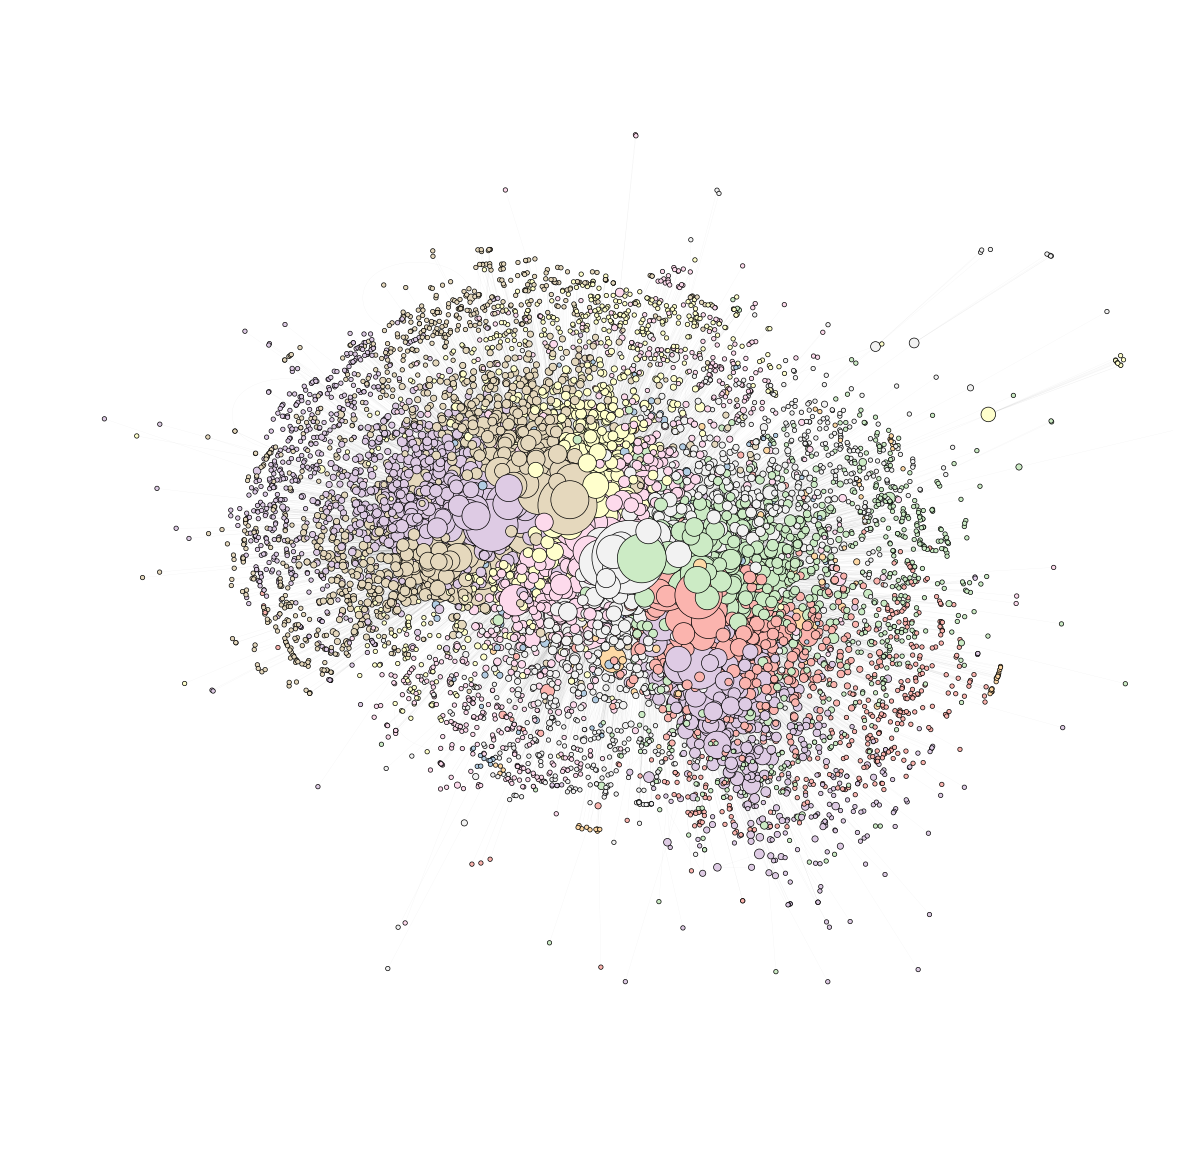

In [54]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from matplotlib.colors import to_hex
import matplotlib.transforms as transforms

# Generate a unique pastel color for each node
node_colors = [user_color_map[node] for node in G_filtered.nodes]

# Calculate node sizes based on the number of votes (degree in the graph)
node_sizes = [G_filtered.degree(node) * 10 for node in G_filtered.nodes]

# Generate a single consistent layout
pos = nx.spring_layout(G_filtered, seed=42)

# Create the figure
fig, ax = plt.subplots(figsize=(15, 15))

# Apply a rotation transformation to the plot
rotate = transforms.Affine2D().rotate_deg(90)  # Rotate the graph by 90 degrees
ax.transData = rotate + ax.transData

# Draw edges with high transparency and very thin lines
nx.draw_networkx_edges(
    G_filtered,
    pos=pos,
    ax=ax,
    alpha=0.05,  # High transparency
    width=0.2    # Very thin lines
)

# Draw nodes with sizes and pastel colors
nx.draw_networkx_nodes(
    G_filtered,
    pos=pos,
    ax=ax,
    node_size=node_sizes,
    node_color=node_colors,
    linewidths=0.5,  # Add a thin black outline to nodes
    edgecolors="black"
)

# Remove axes for better aesthetics
plt.axis("off")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms

# Create a sample plot
fig, ax = plt.subplots()
ax.plot([0, 1, 2], [0, 1, 4])

# Apply a rotation transformation
rotate = transforms.Affine2D().rotate_deg(90)  # Rotate by 90 degrees
ax.transData = rotate + ax.transData

plt.show()

In [32]:
graph_html = fig.to_html(full_html=False, include_plotlyjs='cdn')

# Enregistrer le HTML dans un fichier
with open("../../docs/_includes/plots/user_graph2.html", "w") as f:
    f.write(graph_html)


[nan, '(aeropagitica)', '23skidoo', '@pple', 'AYArktos', 'Aaron Brenneman', 'Abela2006', 'Acetic Acid', 'Agathoclea', 'Airplaneman', 'Alex S', 'AlexandrDmitri', 'AlexiusHoratius', 'Alison', 'Ambuj.Saxena', 'AndonicO', 'Andrew c', 'Andrwsc', 'Andy5190', 'Antandrus', 'Appleboy', 'Arkyan', 'Arvindn', 'Audi152', 'Avruch', 'Babajobu', 'Backslash Forwardslash', 'Bahamut0013', 'Banaticus', 'Bastique', 'Bbb23', 'Bduke', 'Bellhalla', 'Benon3', 'Benon4', 'Benon5', 'Betacommand', 'Bhadani', 'Bibliomaniac15', 'Bigtimepeace', 'Bjelleklang', 'Bobo192', 'Bongwarrior', 'Bookofjude', 'Bottesini', 'Bradjamesbrown', 'Brian New Zealand', 'Bubba hotep', 'Bumm13', 'CIreland', 'CRGreathouse', 'Cactus.man', 'Cailil', "Can't sleep, clown will eat me", 'Canadian Paul', 'Canadian-Bacon', 'CanadianCaesar', 'CapitalR', 'Carrite', 'Cbl62', 'Celestianpower', 'Cenarium', 'Ceranthor', 'Chamal N', 'Chaser', 'Choess', 'Cholmes75', 'Chris 73', 'ChrisGriswold', 'Christopher Mahan', 'Circeus', 'Commander Keane', 'CorbinSim